In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [65]:
train = pd.read_csv('/kag/input/godaddy-microbusiness-density-forecasting/train.csv')
test = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
sample = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv')

In [18]:
train['first_day_of_month'] = pd.to_datetime(train['first_day_of_month'])
test['first_day_of_month'] = pd.to_datetime(test['first_day_of_month'])
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [19]:
test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


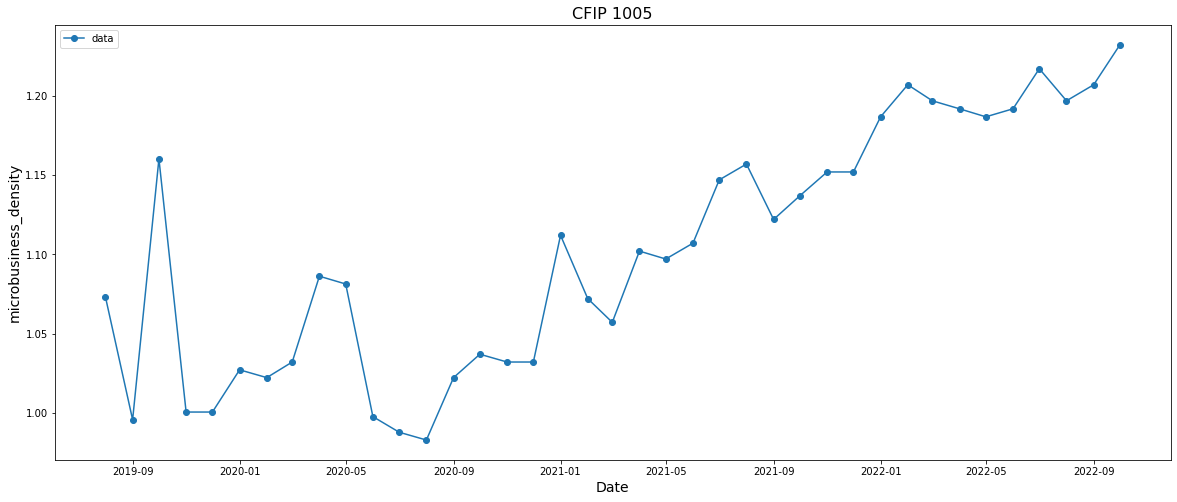

In [22]:
import matplotlib.pyplot as plt
data = train.loc[train.cfips == 1005]
plt.figure(figsize = (20,8))
plt.plot(data.first_day_of_month, data.microbusiness_density,'-o', label='data')
plt.title('CFIP 1005', size = 16)
plt.xlabel('Date', size = 14)
plt.ylabel('microbusiness_density', size=14)
plt.legend()

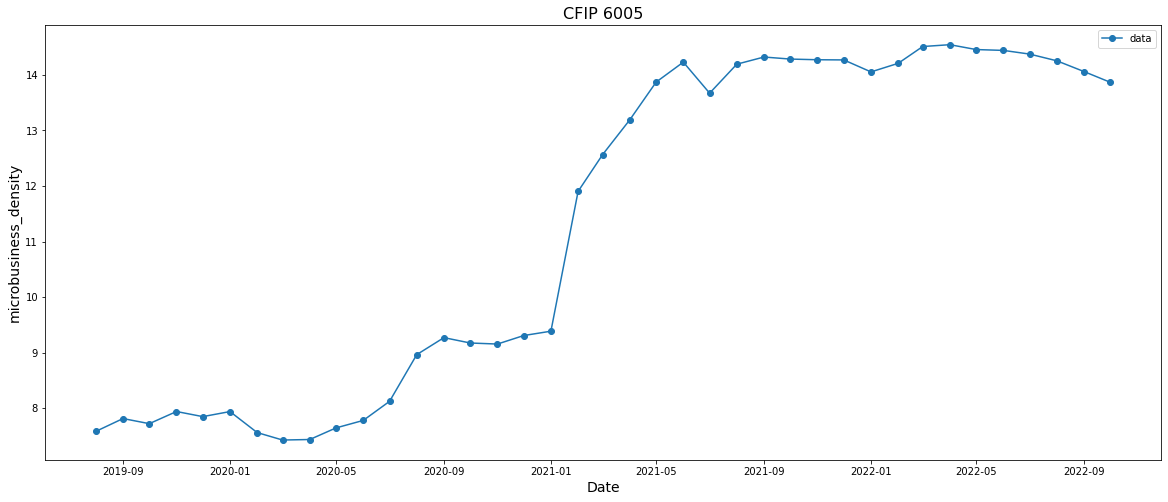

In [23]:
import matplotlib.pyplot as plt
data = train.loc[train.cfips == 6005]
plt.figure(figsize = (20,8))
plt.plot(data.first_day_of_month, data.microbusiness_density,'-o', label='data')
plt.title('CFIP 6005', size = 16)
plt.xlabel('Date', size = 14)
plt.ylabel('microbusiness_density', size=14)
plt.legend()

In [31]:
train['cfips'].unique().size

3135

In [58]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(data):
    result = adfuller(data)
    labels = ['ADS statistic', 'p', 'lags', 'no. of obs']
    
    for i, c in zip(result, labels):
        print(c+':'+str(i))

In [59]:
adfuller_test(train['microbusiness_density'])

ADS statistic:-30.83611628321527
p:0.0
lags:61
no. of obs:122203


In [39]:
df = train[['microbusiness_density', 'cfips', 'first_day_of_month']].copy(deep=True)

In [41]:
df = df.groupby(['cfips', 'first_day_of_month']).sum()

In [42]:
df

microbusiness_density
cfips first_day_of_month                       
1001  2019-08-01                       3.007682
      2019-09-01                       2.884870
      2019-10-01                       3.055843
      2019-11-01                       2.993233
      2019-12-01                       2.993233
...                                         ...
56045 2022-06-01                       1.803249
      2022-07-01                       1.803249
      2022-08-01                       1.785395
      2022-09-01                       1.785395
      2022-10-01                       1.785395

[122265 rows x 1 columns]

In [48]:
df_t = test.groupby(['cfips', 'first_day_of_month']).sum()

In [49]:
df_t

row_id
cfips first_day_of_month                  
1001  2022-11-01           1001_2022-11-01
      2022-12-01           1001_2022-12-01
      2023-01-01           1001_2023-01-01
      2023-02-01           1001_2023-02-01
      2023-03-01           1001_2023-03-01
...                                    ...
56045 2023-02-01          56045_2023-02-01
      2023-03-01          56045_2023-03-01
      2023-04-01          56045_2023-04-01
      2023-05-01          56045_2023-05-01
      2023-06-01          56045_2023-06-01

[25080 rows x 1 columns]

In [61]:
from statsmodels.tsa.arima.model import ARIMA

In [64]:
df_t['microbusiness_density'] = 0
for i in train['cfips'].unique():

    history_p = [x[0] for x in df.loc[int(i),:].values]
    model = ARIMA(history_p, order = (2,1,0))
    model_fit = model.fit()
    
    forecast = np.array(model_fit.predict(start = 39,end = 46,typ = 'levels'))

    for j in range(len(forecast)):
        df_t.loc[int(i), 'microbusiness_density'] = forecast[j]
        
df_t.index = range(0,len(test))

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: 

In [66]:
df_t

,row_id,microbusiness_density
0,1001_2022-11-01,3.469192
1,1001_2022-12-01,3.469192
2,1001_2023-01-01,3.469192
3,1001_2023-02-01,3.469192
4,1001_2023-03-01,3.469192
...,...,...
25075,56045_2023-02-01,1.785395
25076,56045_2023-03-01,1.785395
25077,56045_2023-04-01,1.785395
25078,56045_2023-05-01,1.785395


In [71]:
submission = pd.DataFrame({'row_id':sample['row_id'],'microbusiness_density': 0})
df_t_row_id = list(df_t['row_id'])

for i in range(len(submission['row_id'])):
    index = df_t_row_id.index(submission.iloc[i,0])
    submission.iloc[i,1] = df_t.iloc[index,1]

In [72]:
submission.to_csv('submission.csv', index=False)
submission

,row_id,microbusiness_density
0,1001_2022-11-01,3.469192
1,1003_2022-11-01,8.372240
2,1005_2022-11-01,1.218274
3,1007_2022-11-01,1.290400
4,1009_2022-11-01,1.832997
...,...,...
25075,56037_2023-06-01,2.833420
25076,56039_2023-06-01,26.276712
25077,56041_2023-06-01,4.011312
25078,56043_2023-06-01,3.120626
